In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
import tqdm
import random
import glob

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, callbacks, layers, losses
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa

tf.random.set_seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def leakyrelu(x, factor=0.2):
    return tf.maximum(x, factor*x)

In [3]:
class GAN(keras.Model):
    def __init__(self, x_dim, z_dim): # dim: tuple
        super(GAN, self).__init__()
        self.x_dim  = x_dim
        self.z_dim = z_dim

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
    def compile(self, g_optim, d_optim, loss_fn):
        super(GAN, self).compile()
        self.g_optim = g_optim
        self.d_optim = d_optim
        self.loss_fn = loss_fn
        
    def build_generator(self): 
        activation = 'relu'
        inputs = Input(shape=(self.z_dim, ))
        h = Dense(256)(inputs)
        h = Activation(activation)(h)
        h = BatchNormalization(momentum=0.8)(h)
        
        h = Dense(512)(h)
        h = Activation(activation)(h)
        h = BatchNormalization(momentum=0.8)(h)
        
        h = Dense(1024)(h)
        h = Activation(activation)(h)
        
        outputs = Dense(self.x_dim[0], activation='tanh')(h)
        
        return Model(inputs, outputs, name='generator')

    def build_discriminator(self):
        activation = leakyrelu
        inputs = Input(shape = self.x_dim)
        h = Dense(512)(inputs)
        h = Activation(activation)(h)
        
        h = Dense(256)(h)
        h = Activation(activation)(h)
        
        outputs = Dense(1)(h)

        return Model(inputs, outputs, name='discriminator')
    
    def train_step(self, x):
        batch_size = tf.shape(x)[0]
        
        fake_labels = tf.ones((batch_size, 1))
        real_labels = tf.ones((batch_size, 1))*0
        labels = tf.concat([real_labels, fake_labels], 0)
        
        noise = tf.random.normal((batch_size, self.z_dim))
        
        # discriminator
        with tf.GradientTape() as tape:
            fake = self.generator(noise)
            all_x = tf.concat([x, fake], 0)
            preds = self.discriminator(all_x)
            
            d_loss = self.loss_fn(labels, preds)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optim.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # generator
        with tf.GradientTape() as tape:
            fake = self.generator(noise)
            preds = self.discriminator(fake)

            g_loss = self.loss_fn(real_labels, preds)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss}

In [4]:
class PlotCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            r, c = 2, 5
            noise = np.random.normal(0, 1, (r*c, 100))
            imgs = self.model.generator.predict(noise)*0.5 +0.5
            imgs = imgs.reshape(r*c, 28, 28)
            fig, axs = plt.subplots(r, c)
            n = 0
            for i in range(r):
                for j in range(c):
                    axs[i,j].imshow(imgs[n], cmap='gray')
                    axs[i,j].axis('off')
                    n += 1
            plt.show()
            plt.close()

In [5]:
from tensorflow.keras.datasets import mnist
(train_X, train_y), (_, _) = mnist.load_data()
train_X = (train_X - 127.5)/127.5
train_X = train_X.reshape(-1, 28*28)

In [6]:
gan = GAN(train_X.shape[1:], 100)
gan.generator.summary()
print('#'*50)
gan.discriminator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               20

Epoch 1/101
1868/1875 [============================>.] - ETA: 0s - d_loss: 0.4469 - g_loss: 2.0516

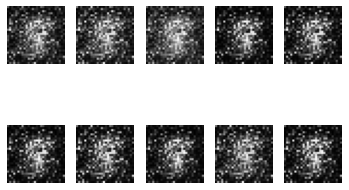

1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.4460 - g_loss: 2.0518
Epoch 2/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.3063 - g_loss: 2.6151
Epoch 3/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.4013 - g_loss: 1.9749
Epoch 4/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.4756 - g_loss: 1.5683
Epoch 5/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.5260 - g_loss: 1.3509
Epoch 6/101
1875/1875 [==============================] - 7s 4ms/step - d_loss: 0.5511 - g_loss: 1.2431
Epoch 7/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.5689 - g_loss: 1.2081
Epoch 8/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.5850 - g_loss: 1.1570
Epoch 9/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.5891 - g_loss: 1.1444
Epoch 10/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.591

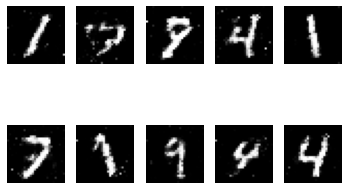

1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.5963 - g_loss: 1.1264
Epoch 12/101
1875/1875 [==============================] - 5s 2ms/step - d_loss: 0.6054 - g_loss: 1.1133
Epoch 13/101
1875/1875 [==============================] - 4s 2ms/step - d_loss: 0.6089 - g_loss: 1.0992
Epoch 14/101
1875/1875 [==============================] - 5s 2ms/step - d_loss: 0.6107 - g_loss: 1.0938
Epoch 15/101
1875/1875 [==============================] - 5s 2ms/step - d_loss: 0.6104 - g_loss: 1.0850
Epoch 16/101
1875/1875 [==============================] - 4s 2ms/step - d_loss: 0.6162 - g_loss: 1.0727
Epoch 17/101
1875/1875 [==============================] - 4s 2ms/step - d_loss: 0.6137 - g_loss: 1.0799
Epoch 18/101
1875/1875 [==============================] - 5s 2ms/step - d_loss: 0.6139 - g_loss: 1.0751
Epoch 19/101
1875/1875 [==============================] - 4s 2ms/step - d_loss: 0.6148 - g_loss: 1.0705
Epoch 20/101
1875/1875 [==============================] - 4s 2ms/step - d_los

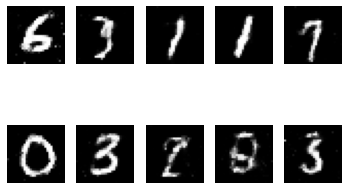

1875/1875 [==============================] - 5s 2ms/step - d_loss: 0.6177 - g_loss: 1.0643
Epoch 22/101
1875/1875 [==============================] - 4s 2ms/step - d_loss: 0.6180 - g_loss: 1.0643
Epoch 23/101
1875/1875 [==============================] - 4s 2ms/step - d_loss: 0.6183 - g_loss: 1.0661
Epoch 24/101
1875/1875 [==============================] - 5s 2ms/step - d_loss: 0.6220 - g_loss: 1.0549
Epoch 25/101
1875/1875 [==============================] - 5s 2ms/step - d_loss: 0.6214 - g_loss: 1.0523
Epoch 26/101
1875/1875 [==============================] - 5s 2ms/step - d_loss: 0.6228 - g_loss: 1.0497
Epoch 27/101
1875/1875 [==============================] - 5s 2ms/step - d_loss: 0.6239 - g_loss: 1.0465
Epoch 28/101
1875/1875 [==============================] - 4s 2ms/step - d_loss: 0.6229 - g_loss: 1.0487
Epoch 29/101
1875/1875 [==============================] - 5s 2ms/step - d_loss: 0.6232 - g_loss: 1.0454
Epoch 30/101
1875/1875 [==============================] - 5s 2ms/step - d_los

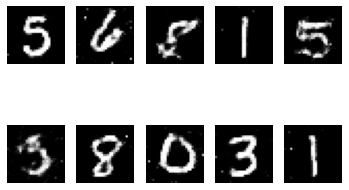

1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6213 - g_loss: 1.0474
Epoch 32/101
1875/1875 [==============================] - 7s 4ms/step - d_loss: 0.6227 - g_loss: 1.0462
Epoch 33/101
1875/1875 [==============================] - 8s 4ms/step - d_loss: 0.6229 - g_loss: 1.0397
Epoch 34/101
1875/1875 [==============================] - 10s 5ms/step - d_loss: 0.6241 - g_loss: 1.0417
Epoch 35/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6217 - g_loss: 1.0454
Epoch 36/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6207 - g_loss: 1.0458
Epoch 37/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6199 - g_loss: 1.0491
Epoch 38/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6185 - g_loss: 1.0551
Epoch 39/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6197 - g_loss: 1.0522
Epoch 40/101
1875/1875 [==============================] - 11s 6ms/step 

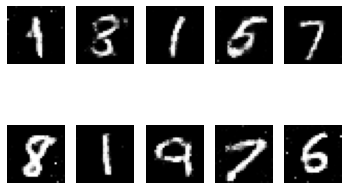

1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6166 - g_loss: 1.0566
Epoch 42/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6174 - g_loss: 1.0608
Epoch 43/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6168 - g_loss: 1.0534
Epoch 44/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6171 - g_loss: 1.0534
Epoch 45/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6179 - g_loss: 1.0551
Epoch 46/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6160 - g_loss: 1.0581
Epoch 47/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6157 - g_loss: 1.0585
Epoch 48/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6150 - g_loss: 1.0635
Epoch 49/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6130 - g_loss: 1.0644
Epoch 50/101
1875/1875 [==============================] - 11s 6ms/st

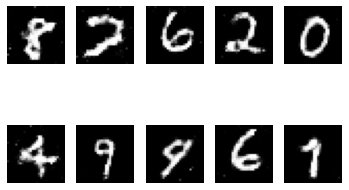

1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6132 - g_loss: 1.0633
Epoch 52/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6123 - g_loss: 1.0648
Epoch 53/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6113 - g_loss: 1.0717
Epoch 54/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6118 - g_loss: 1.0676
Epoch 55/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6100 - g_loss: 1.0718
Epoch 56/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6090 - g_loss: 1.0825
Epoch 57/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6062 - g_loss: 1.0838
Epoch 58/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6087 - g_loss: 1.0831
Epoch 59/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6065 - g_loss: 1.0854
Epoch 60/101
1875/1875 [==============================] - 11s 6ms/st

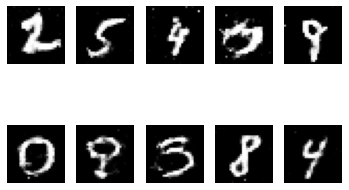

1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6065 - g_loss: 1.0845
Epoch 62/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6061 - g_loss: 1.0871
Epoch 63/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6046 - g_loss: 1.0932
Epoch 64/101
1875/1875 [==============================] - 12s 6ms/step - d_loss: 0.6024 - g_loss: 1.0986
Epoch 65/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6033 - g_loss: 1.0987
Epoch 66/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6032 - g_loss: 1.1018
Epoch 67/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6011 - g_loss: 1.1039
Epoch 68/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.6008 - g_loss: 1.1074
Epoch 69/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5981 - g_loss: 1.1117
Epoch 70/101
1875/1875 [==============================] - 11s 6ms/st

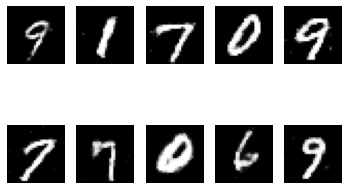

1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5973 - g_loss: 1.1179
Epoch 72/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5958 - g_loss: 1.1229
Epoch 73/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5959 - g_loss: 1.1223
Epoch 74/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5963 - g_loss: 1.1220
Epoch 75/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5958 - g_loss: 1.1267
Epoch 76/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5966 - g_loss: 1.1248
Epoch 77/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5936 - g_loss: 1.1299
Epoch 78/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5934 - g_loss: 1.1295
Epoch 79/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5944 - g_loss: 1.1299
Epoch 80/101
1875/1875 [==============================] - 11s 6ms/st

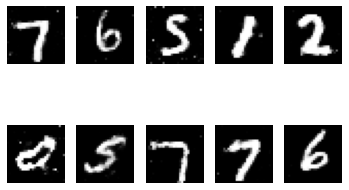

1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5917 - g_loss: 1.1355
Epoch 82/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5907 - g_loss: 1.1429
Epoch 83/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5902 - g_loss: 1.1413
Epoch 84/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5865 - g_loss: 1.1542
Epoch 85/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5863 - g_loss: 1.1515
Epoch 86/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5862 - g_loss: 1.1558
Epoch 87/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5854 - g_loss: 1.1640
Epoch 88/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5866 - g_loss: 1.1571
Epoch 89/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5847 - g_loss: 1.1636
Epoch 90/101
1875/1875 [==============================] - 11s 6ms/st

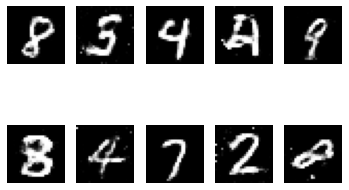

1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5835 - g_loss: 1.1702
Epoch 92/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5811 - g_loss: 1.1786
Epoch 93/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5801 - g_loss: 1.1791
Epoch 94/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5804 - g_loss: 1.1778
Epoch 95/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5793 - g_loss: 1.1831
Epoch 96/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5772 - g_loss: 1.1903
Epoch 97/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5773 - g_loss: 1.1912
Epoch 98/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5754 - g_loss: 1.1915
Epoch 99/101
1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5744 - g_loss: 1.1976
Epoch 100/101
1875/1875 [==============================] - 11s 6ms/s

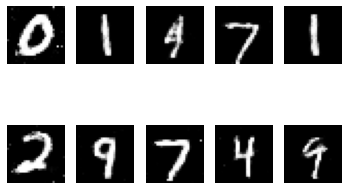

1875/1875 [==============================] - 11s 6ms/step - d_loss: 0.5750 - g_loss: 1.2017


In [7]:
gan.compile(
    optimizers.Adam(2e-4, 0.5), 
    optimizers.Adam(2e-4, 0.5), 
    losses.BinaryCrossentropy(from_logits=True), 
         )

gan.fit(train_X,
       epochs=101,
       shuffle=True,
       batch_size=32,
       callbacks=[PlotCallback()])